In [1]:
import numpy as np
import math
from mpmath import mp
# pip install mpmath
import matplotlib.pyplot as plt
import time as time
%matplotlib inline
#import scipy.special as sp

In [2]:
# Constants
mu0 	= 4*math.pi*10**-7; 			# Vs/Am
eps0	= 8.854*10**-12; 				# As/Vm
c0 		= 299792457; 					# m/s

# shortcuts for Schelkunoff
i0 = lambda x: mp.besseli(0,x)
i1 = lambda x: mp.besseli(1,x)
k0 = lambda x: mp.besselk(0,x)
k1 = lambda x: mp.besselk(1,x)

############
# Thomas numbers
############

# a		= 0.25/2*10**-3;                # mm
# b		= 135/2*10**-3;                 # mm
# c		= 139.7/2*10**-3;               # mm
# sigma	= 5.76*10**7; 					# 1/Ohm*m
# epsPE   = 1.0; 

############
# Tesche numbers
############

a		= 2.5*10**-3;					# mm
b		= 9.345*10**-3;                 # mm
c		= 9.945*10**-3;          		# mm
sigma	= 5.76*10**7; 					# 1/Ohm*m
epsPE   = 2.5; 

############
# RG58 or Jans numbers
############

a		= 0.4675*10**-3;                # mm
b		= 1.475*10**-3;                 # mm
c		= 1.8 *10**-3;              	# mm
sigma	= 5.8*10**7; 					# 1/Ohm*m
epsPE   = 1.9; 

In [3]:
# in 10^low, 10^high
def generateFrequencyRange(low, high, N):
    f = np.logspace(low, high, N)
    omega = 2*np.pi*f;
    return f, omega

In [4]:
# innerR = a, outerR = b, outerR_dist = c
def model_Tesche(omega, a, b, c, sigma, eps_rel, mu_rel = 1): 
    t = time.time(); 
    Lp = mu0/(2*math.pi)*np.log(b/a); 			    # ln(ra/ri)
    Cp = 2*math.pi*eps0*epsPE/(np.log(b/a)); 	    # ln(ra/ri)
    
    # HF
    # Inner conductor
    RaHFp = 1/(2*np.pi*a)*np.sqrt(omega * mu0 / (2*sigma)); 
    LaHFp = 1/(2*np.pi*a)*np.sqrt(mu0 / (2*omega*sigma)); 
    
    # Outer conductor
    #ZbHFp	= (1+i)/(2*np.pi*b)*np.sqrt(omega*mu0/(2*sigma)); # = 1/(2*np.pi*a)*np.sqrt(i*omega*mu0/sigma) 
    #yields
    RbHFp = 1/(2*np.pi*b)*np.sqrt(omega * mu0/(2*sigma)); 
    LbHFp = 1/(2*np.pi*b)*np.sqrt(mu0 / (2*omega*sigma)); 
    
    # LF
    RaDCp = 1/(np.pi*a**2*sigma); 
    LaIntp = mu0/(8*np.pi); 
    RbDCp = 1/(np.pi*(c**2 - b**2)*sigma); 
    LbIntp = mu0/(2*np.pi) * (c**4 * np.log(c/b) / (c**2 - b**2)**2 + (b**2 - 3*c**2)/(4*(c**2 - b**2)));
    
    # Combine
    Zap     = RaDCp + (1j*omega*LaIntp * (RaHFp + 1j * omega * LaHFp)) / (RaHFp + 1j*omega * (LaHFp + LaIntp)); 
    Zbp     = RbDCp + (1j*omega*LbIntp * (RbHFp + 1j * omega * LbHFp)) / (RbHFp + 1j*omega * (LbHFp + LbIntp)); 
    
    Ztot = Zap + Zbp + 1j*omega*Lp; 
    Ytot = 1j*omega*Cp; 
    
    gamma = np.sqrt(Ztot*Ytot); 
    Zc = np.sqrt(Ztot/Ytot); 
    
    print("Tesche model built in %f s."%(time.time() - t))
    return Zc, gamma

In [5]:
def model_Schelkunoff(omega, a, b, c, sigma, eps_rel, mu_rel = 1): 
    t = time.time(); 
    eta = np.sqrt(1j*omega*mu0*mu_rel/sigma); 
    gammac = np.sqrt(1j*omega*mu0*mu_rel*sigma); 
    ### Does not work because mpmath variables cannot be created from array :-( 
    
    #Zap = eta/(2*np.pi*a) * ( i0(gammac*a) / i1(gammac*a) )
    #Zbp = eta/(2*np.pi*b) * ((i0(gammac*b) * k1(gammac*c) + k0(gammac*b)*i1(gammac*c)) / ( i1(gammac*c)*k1(gammac*b) - i1(gammac*b)*k1(gammac*c) ) )
    Zap = mp.matrix(len(omega), 1);
    Zbp = Zap.copy(); 
    Zc_real = mp.matrix(len(omega), 1); Zc_imag = Zc_real.copy(); Zc_abs = Zc_real.copy(); 
    gamma_real = Zc_real.copy(); gamma_imag = Zc_real.copy(); gamma_abs = gamma_real.copy(); 

    Cp = 2*np.pi * eps0*eps_rel / ( np.log(b/a) ); 
    Lp = mu0*mu_rel / (2*np.pi) * np.log(b/a); 

    for n in range(omega.size): 
        Zap[n] = eta[n]/(2*np.pi*a) * ( i0(gammac[n]*a) / i1(gammac[n]*a) )
        Zbp[n] = eta[n]/(2*np.pi*b) * ((i0(gammac[n]*b) * k1(gammac[n]*c) + k0(gammac[n]*b)*i1(gammac[n]*c)) / ( i1(gammac[n]*c)*k1(gammac[n]*b) - i1(gammac[n]*b)*k1(gammac[n]*c) ) )
        
        Zp = 1j*omega*Lp + Zap + Zbp; 
        Yp = 1j*omega*Cp;
        Zc = mp.sqrt(Zp[n] / Yp[n]); 
        Zc_real[n] = mp.re(Zc);
        Zc_imag[n] = mp.im(Zc); 
        Zc_abs[n] = mp.fabs(Zc)
        gamma = mp.sqrt(Zp[n] * Yp[n]); 
        gamma_real[n] = mp.re(gamma); 
        gamma_imag[n] = mp.im(gamma); 
        gamma_abs[n] = mp.fabs(gamma); 
    
    print("Schelkunoff model built in %f s."%(time.time() - t))
    return Zc_real, Zc_imag, Zc_abs, gamma_real, gamma_imag, gamma_abs

In [6]:
def plotZc(f, Zc, logscale=False): 
    fig = plt.figure()
    if (not logscale): 
        plt.plot(f/10**6, np.abs(Zc), label='Amplitude', color='red')
        plt.xlim([-0.3,100])
        plt.xlabel('Frequency [MHz]')
    else: 
        plt.semilogx(f/10**3, np.abs(Zc), label='Magnitude', color='red')
        plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude of Z$_{c}$ [$\Omega$]')
    plt.legend()

    fig2 = plt.figure()
    if (not logscale): 
        plt.plot(f/10**6, Zc.real, label='Real part', color='red')
        plt.xlim([-0.3,100])
        plt.xlabel('Frequency [MHz]')
    else: 
        plt.semilogx(f/10**3, Zc.real, label='Real part', color='red')
        plt.xlabel('Frequency [Hz]')
    plt.ylabel('Real Part of Z$_{c}$ [$\Omega$]')
    plt.legend()
    
    fig2 = plt.figure()
    if (not logscale): 
        plt.plot(f/10**6, Zc.imag, label='Imaginary Part', color='red')
        plt.xlim([-0.3,100])
        plt.xlabel('Frequency [MHz]')
    else: 
        plt.semilogx(f/10**3, Zc.imag, label='Imaginary Part', color='red')
        plt.xlabel('Frequency [Hz]')
    plt.ylabel('Imaginary Part of Z$_{c}$ [$\Omega$]')
    plt.legend(loc='lower right')

    plt.show()

def plotZcCombined(f, Zc, logscale=False): 
    fig = plt.figure()
    if (not logscale): 
        plt.plot(f/10**6, np.abs(Zc), label='Amplitude', color='red')
        plt.plot(f/10**6, Zc.real, label='Real Part', color='blue')
        plt.plot(f/10**6, Zc.imag, label='Imaginary Part', color='green')
        plt.xlim([-0.3, 100])
        plt.xlabel('Frequency [MHz]')
    else: 
        plt.semilogx(f/10**3, np.abs(Zc), label='Magnitude', color='red')
        plt.semilogx(f/10**3, Zc.real, label='Real Part', color='blue')
        plt.semilogx(f/10**3, Zc.imag, label='Imaginary Part', color='green')
        plt.xlabel('Frequency [Hz]')
    # check Frequency labelling!
    plt.ylabel('Characteristic Impedance Z$_c$ [$\Omega$]')
    plt.legend()
    plt.show()
    
def plotPropConst(f, gamma, logscale=False): 
    fig = plt.figure()
    if (not logscale): 
        plt.plot(f/10**6, np.abs(gamma), label='Magnitude', color='red')
        plt.xlim([-0.3,100])
        plt.xlabel('Frequency [MHz]')
    else: 
        plt.loglog(f/10**3, np.abs(gamma), label='Magnitude', color='red')
        plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude of $\gamma$ [$1/m$]')
    plt.legend()

    fig2 = plt.figure()
    if (not logscale): 
        plt.plot(f/10**6, gamma.real, label='Attenuation', color='red')
        plt.xlim([-0.3,100])
        plt.xlabel('Frequency [MHz]')
    else: 
        plt.loglog(f/10**3, gamma.real, label='Attenuation', color='red')
        plt.xlabel('Frequency [Hz]')
    plt.ylabel(r'Attenuation Constant $\alpha$ [$1/m$]')
    plt.legend()

    fig3 = plt.figure()
    if (not logscale): 
        plt.plot(f/10**6, gamma.imag, label='Phase', color='red')
        plt.xlim([-0.3,100])
        plt.xlabel('Frequency [MHz]')
    else: 
        plt.loglog(f/10**3, gamma.imag, label='Phase', color='red')
        plt.xlabel('Frequency [Hz]')
    plt.ylabel(r'Phase constant $\beta$ [$1/m$]')
    plt.legend()

    plt.show()

In [7]:
def compareModels_Zc(omega, Zc, Zcr, Zci, Zca): 
    fig = plt.figure()
    plt.plot(f/10**6, np.abs(Zc), label='Amplitude Tesche', color='red')
    plt.plot(f/10**6, Zca, "x", label='Amplitude Schelkunoff', color='blue')
    plt.xlim([-0.3,100])
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Magnitude of Z$_{c}$ [$\Omega$]')
    plt.legend()

    fig2 = plt.figure()
    plt.plot(f/10**6, Zc.real, label='Real part Tesche', color='red')
    plt.plot(f/10**6, Zcr, "x", label='Real part Schelkunoff', color='blue')
    plt.xlim([-0.3,100])
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Real Part of Z$_{c}$ [$\Omega$]')
    plt.legend()
    
    fig2 = plt.figure()
    plt.plot(f/10**6, Zc.imag, label='Imaginary Part Tesche', color='red')
    plt.plot(f/10**6, Zci, "x", label='Imaginary Part Schelkunoff', color='blue')
    plt.xlim([-0.3,100])
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Imaginary Part of Z$_{c}$ [$\Omega$]')
    plt.legend(loc='lower right')

    plt.show()
    
def compareModels_Gamma(omega, gamma, gammar, gammai, gammaa): 
    fig = plt.figure()
    plt.plot(f/10**6, np.abs(gamma), label='Magnitude Tesche', color='red')
    plt.plot(f/10**6, gammaa, "x", label='Magnitude Schelkunoff', color='blue')
    plt.xlim([-0.3,100])
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Magnitude of $\gamma$ [$1/m$]')
    plt.legend(loc='lower right')

    fig2 = plt.figure()
    plt.loglog(f/10**6, gamma.real, label='Attenuation Tesche', color='red')
    plt.loglog(f/10**6, gammar, "x", label='Attenuation Schelkunoff', color='blue')
    plt.xlabel('Frequency [MHz]')
    plt.ylabel(r'Attenuation Constant $\alpha$ [$1/m$]')
    plt.legend(loc='lower right')

    fig3 = plt.figure()
    plt.loglog(f/10**6, gamma.imag, label='Phase Tesche', color='red')
    plt.loglog(f/10**6, gammai, "x", label='Phase Schelkunoff', color='blue')
    plt.xlabel('Frequency [MHz]')
    plt.ylabel(r'Phase constant $\beta$ [$1/m$]')
    plt.legend(loc='lower right')

    plt.show()

In [8]:
f, omega = generateFrequencyRange(5, 8, 100)

In [9]:
Zc, gamma = model_Tesche(omega, a, b, c, sigma, epsPE)

Tesche model built in 0.000712 s.


In [10]:
Zcr, Zci, Zca, gammar, gammai, gammaa= model_Schelkunoff(omega, a, b, c, sigma, epsPE)

Schelkunoff model built in 5.952910 s.


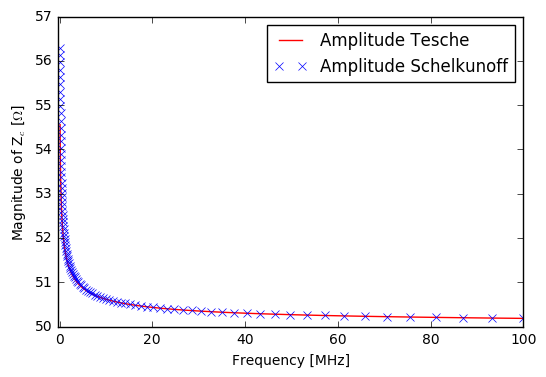

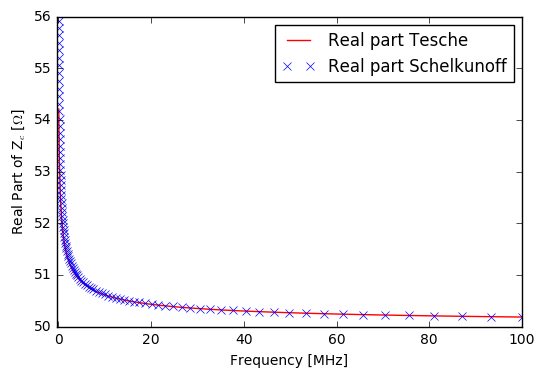

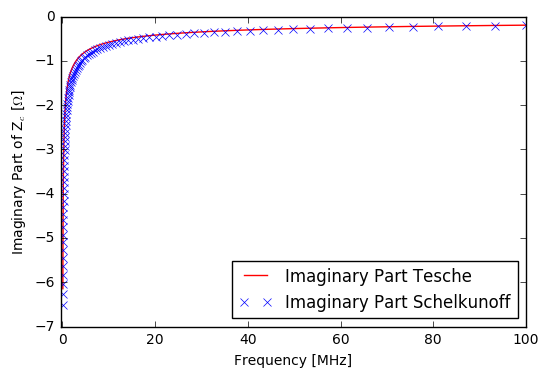

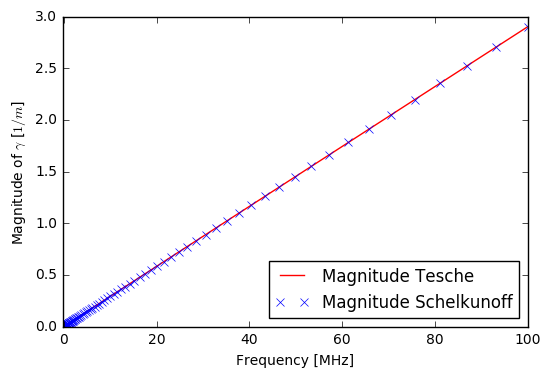

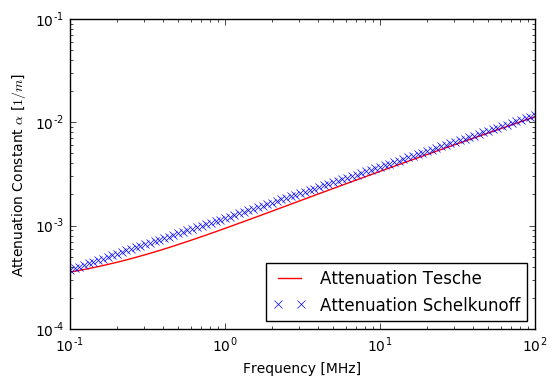

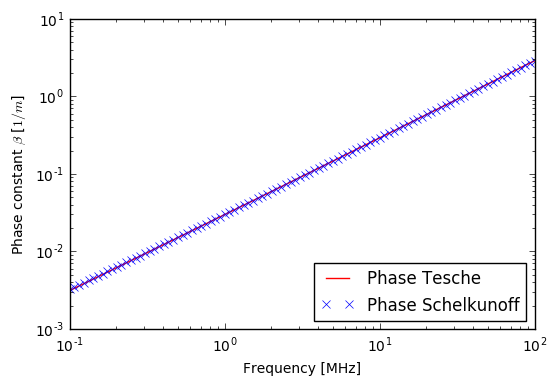

In [11]:
compareModels_Zc(omega, Zc, Zcr, Zci, Zca)
compareModels_Gamma(omega, gamma, gammar, gammai, gammaa)